<a href="https://colab.research.google.com/github/nkumarcc/tf-attention-is-all-you-need/blob/main/Attention_is_All_You_Need_Take_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from platform import python_version
python_version()

'3.10.6'

In [3]:
!python -m spacy download de_core_news_sm
!python -m spacy download en_core_web_sm

2023-07-22 04:28:17.856103: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-22 04:28:18.899489: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-07-22 04:28:20.292787: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-22 04:28:20.293265: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

In [4]:
!pip install portalocker

In [5]:
!pip install --upgrade torchtext

# 1. Need to import data

In [6]:
from torchtext.datasets import IWSLT2017

# Set the source and target language
SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'

# Get the training, validation and test data
train_iter, val_iter, test_iter = IWSLT2017(
    './drive/MyDrive/Colab_Notebooks_Assets/attention_is_all_you_need/data',
    split=('train', 'valid', 'test'),
    language_pair=(SRC_LANGUAGE, TGT_LANGUAGE)
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/datapipes/utils/common.py:137: UserWarning: Local function is not supported by pickle, please use regular python function or functools.partial instead.
  warnings.warn(


# 2. Build the model

**Scaled Dot Product Attention:**

"""
Inputs:
- Q - n x d_k
- K - n x d_k
- V - n x d_v
- mask: Whether or not to mask earlier values (for the output decoder)

Outputs:
- X - n x d_v
"""

**Multi-Head Attention:**

"""
Params:
- num_heads = Number of parallel layers (h in the paper)
- d_model = d_v * h. We're in general setting d_v and d_k equal in the paper/implementation
- d_k = dim of queries/keys
- d_v = dim of values

Inputs:
- Q - n x d_k
- K - n x d_k
- V - n x d_v
- mask: Whether or not to mask earlier values (for the output decoder)

Outputs:
- Z - n x d_v
"""

In [7]:
import pdb
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class PositionalEmbedding(nn.Module):
    def __init__(self, vocab_size, d_model=512):
        super(PositionalEmbedding, self).__init__()
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model)

    def forward(self, X):
        X = self.token_embedding(X)
        return self.positional_encoding(X)

class FeedForward(nn.Module):
    def __init__(self, d_model=512, d_ff=2048):
        super(FeedForward, self).__init__()
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.linear_2 = nn.Linear(d_ff, d_model)

    def forward(self, X):
        X = self.linear_1(X)
        X = F.relu(X)
        return self.linear_2(X)

class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()

    def forward(self, Q, K, V, mask=False):
        Z = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(K.size(-1))
        if mask:
          mask = torch.tril(torch.ones(Z.shape)).bool().to(Z.device)
          Z = Z.masked_fill(~mask, float('-inf'))
        Z = F.softmax(Z, dim=-1)
        return torch.matmul(Z, V)

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads=8, d_model=512, d_data=64):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_data = d_data

        self.Q_linears = nn.Linear(d_model, d_data * num_heads)
        self.K_linears = nn.Linear(d_model, d_data * num_heads)
        self.V_linears = nn.Linear(d_model, d_data * num_heads)
        self.attention = ScaledDotProductAttention()
        self.output_linear = nn.Linear(d_model, d_model)

    def forward(self, Q, K, V, mask=False):
        batch_size = Q.size(0)

        Q = self.Q_linears(Q).view(batch_size, -1, self.num_heads, self.d_data).transpose(1, 2)
        K = self.K_linears(K).view(batch_size, -1, self.num_heads, self.d_data).transpose(1, 2)
        V = self.V_linears(V).view(batch_size, -1, self.num_heads, self.d_data).transpose(1, 2)

        Z = self.attention(Q, K, V, mask)
        Z = Z.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.d_data)

        return self.output_linear(Z)

class Encoder(nn.Module):
    def __init__(self, num_heads=8, d_model=512, d_data=64):
        super(Encoder, self).__init__()
        self.mha = MultiHeadAttention(num_heads, d_model, d_data)
        self.add_norm_mha = nn.LayerNorm(d_model)
        self.feed_forward = FeedForward(d_model, d_model * 4)
        self.add_norm_feed_forward = nn.LayerNorm(d_model)

    def forward(self, X):
        X_mha = self.mha(X, X, X)
        X_mha = self.add_norm_mha(X_mha + X)
        Z = self.feed_forward(X_mha)
        Z = self.add_norm_feed_forward(X_mha + Z)
        return Z

class Decoder(nn.Module):
    def __init__(self, num_heads=8, d_model=512, d_data=64):
        super(Decoder, self).__init__()
        self.masked_mha = MultiHeadAttention(num_heads, d_model, d_data)
        self.add_norm_masked_mha = nn.LayerNorm(d_model)
        self.combined_mha = MultiHeadAttention(num_heads, d_model, d_data)
        self.add_norm_combined_mha = nn.LayerNorm(d_model)
        self.feed_forward = FeedForward(d_model, d_model * 4)
        self.add_norm_feed_forward = nn.LayerNorm(d_model)

    def forward(self, X, Z_input):
        X_masked_mha = self.masked_mha(X, X, X, True)
        X_masked_mha = self.add_norm_masked_mha(X_masked_mha + X)
        Z_mha = self.combined_mha(X_masked_mha, Z_input, Z_input)
        Z_mha = self.add_norm_combined_mha(Z_mha + X_masked_mha)
        Z = self.feed_forward(Z_mha)
        Z = self.add_norm_feed_forward(Z_mha + Z)
        return Z

class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, num_layers=6, num_heads=8, d_model=512):
        super(Transformer, self).__init__()
        if d_model % num_heads != 0:
           raise ValueError("d_model is not divisible by num_heads.")
        d_data = d_model // num_heads
        self.src_positional_embedding = PositionalEmbedding(src_vocab_size, d_model)
        self.tgt_positional_embedding = PositionalEmbedding(tgt_vocab_size, d_model)
        self.encoders = nn.ModuleList([Encoder(num_heads, d_model, d_data) for _ in range(num_layers)])
        self.decoders = nn.ModuleList([Decoder(num_heads, d_model, d_data) for _ in range(num_layers)])
        self.linear = nn.Linear(d_model, tgt_vocab_size)

    def forward(self, X, Y):
        X = self.src_positional_embedding(X)
        for encoder in self.encoders:
          X = encoder(X)

        Y = self.tgt_positional_embedding(Y)
        for decoder in self.decoders:
          Y = decoder(Y, X)

        Y = self.linear(Y)
        return F.log_softmax(Y, dim=-1)

# 3. Test components

Positional Encoding

In [8]:
# Positional Encoding

import numpy as np
import matplotlib.pyplot as plt

test_positional_matrix = torch.ones(2048, 1, 512)
positional_encoding_layer = PositionalEncoding(512, 0, 2048)
encoded = positional_encoding_layer(test_positional_matrix)

print(encoded.shape)

torch.Size([2048, 1, 512])


In [9]:
encoded

tensor([[[1.0000, 2.0000, 1.0000,  ..., 2.0000, 1.0000, 2.0000]],

        [[1.8415, 1.5403, 1.8219,  ..., 2.0000, 1.0001, 2.0000]],

        [[1.9093, 0.5839, 1.9364,  ..., 2.0000, 1.0002, 2.0000]],

        ...,

        [[1.1759, 0.0156, 0.8138,  ..., 1.9760, 1.2104, 1.9776]],

        [[0.2667, 0.3201, 1.7015,  ..., 1.9759, 1.2105, 1.9776]],

        [[0.0317, 1.2497, 1.9854,  ..., 1.9759, 1.2106, 1.9776]]])

In [10]:
encoded[:,0,:].shape

torch.Size([2048, 512])

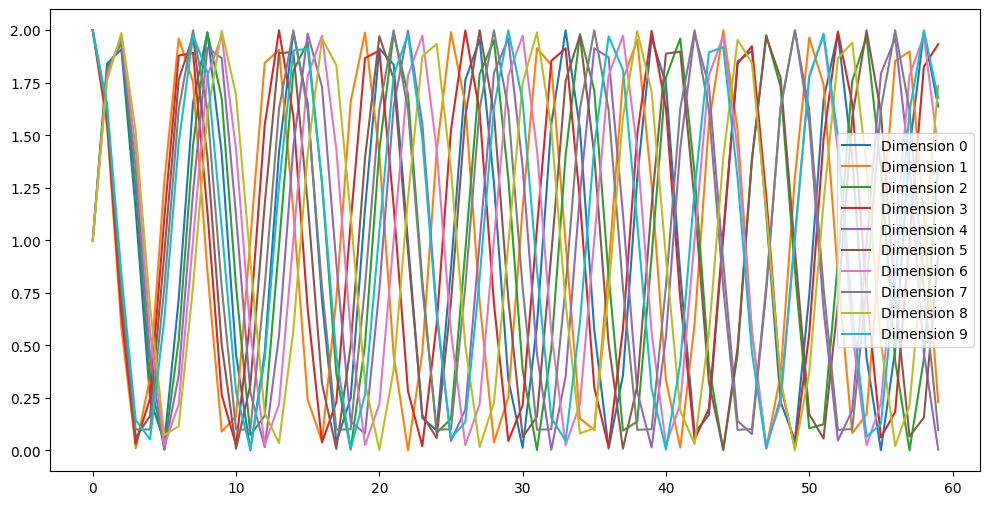

In [11]:
encoded_diag = encoded[:,0,:].detach().numpy()

# Plot the output for some dimensions
plt.figure(figsize=(12, 6))
for i in range(10):  # Change this number to plot more or fewer dimensions
    plt.plot(encoded_diag[:60, i], label=f"Dimension {i}")
plt.legend()
plt.show()

Positional Embedding

In [12]:
test_positional_embedding_matrix = torch.zeros(1, 32, dtype=int)
positional_embedding_layer = PositionalEmbedding(64, 128)
embedded = positional_embedding_layer(test_positional_embedding_matrix)

In [13]:
embedded

tensor([[[ 1.0193,  2.0708,  0.3013,  ...,  1.1593,  1.8525, -0.0570],
         [ 1.0193,  2.0708,  0.3013,  ...,  1.1593,  1.8525, -0.0570],
         [ 1.0193,  2.0708,  0.3013,  ...,  1.1593,  1.8525, -0.0570],
         ...,
         [ 1.0193,  2.0708,  0.3013,  ...,  1.1593,  1.8525, -0.0570],
         [ 1.0193,  2.0708,  0.0000,  ...,  1.1593,  1.8525, -0.0570],
         [ 1.0193,  2.0708,  0.3013,  ...,  1.1593,  1.8525, -0.0570]]],
       grad_fn=<MulBackward0>)

In [14]:
embedded.shape

torch.Size([1, 32, 128])

Feed Forward

In [15]:
ffn = FeedForward()
ffn_input_data = torch.ones(64, 1, 512)
ffn_output = ffn(ffn_input_data)

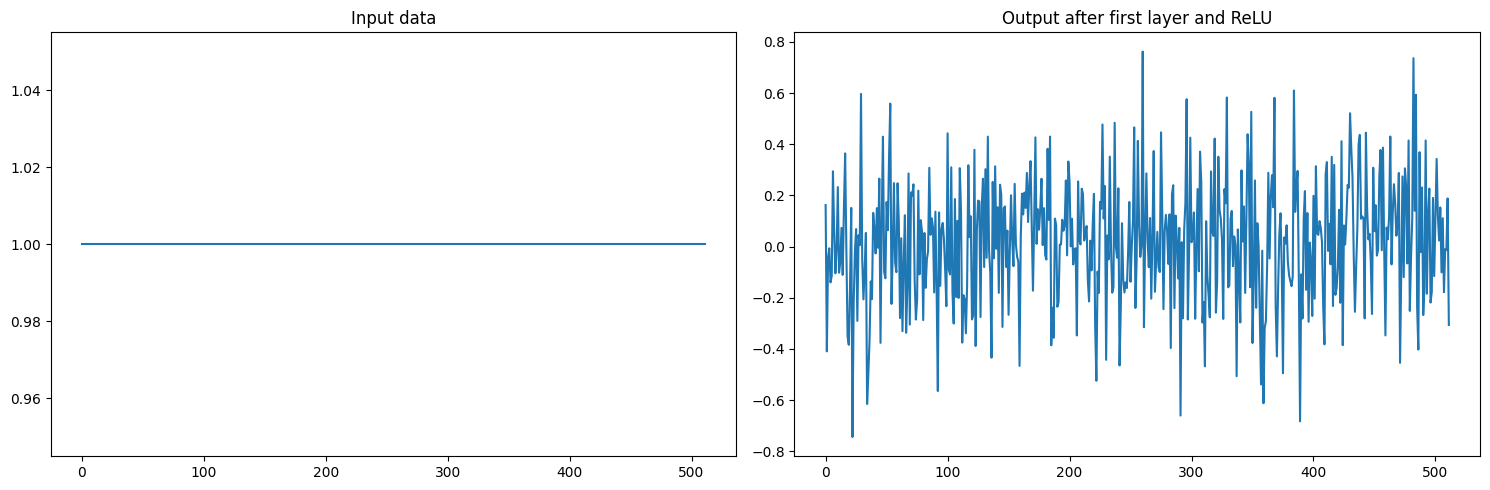

In [16]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('Input data')
plt.plot(ffn_input_data[0][0].detach().numpy())

plt.subplot(1, 2, 2)
plt.title('Output after first layer and ReLU')
plt.plot(ffn_output[0][0].detach().numpy())

plt.tight_layout()
plt.show()

Something happened!

Scaled Dot Product Attention

In [17]:
sdpa = ScaledDotProductAttention()

Q_test = torch.eye(64)
K_test = torch.eye(64)
V_test = torch.eye(64)

output_sdpa_test = sdpa(Q_test, K_test, V_test)

In [18]:
output_sdpa_test.shape

torch.Size([64, 64])

In [19]:
output_sdpa_test

tensor([[0.0177, 0.0156, 0.0156,  ..., 0.0156, 0.0156, 0.0156],
        [0.0156, 0.0177, 0.0156,  ..., 0.0156, 0.0156, 0.0156],
        [0.0156, 0.0156, 0.0177,  ..., 0.0156, 0.0156, 0.0156],
        ...,
        [0.0156, 0.0156, 0.0156,  ..., 0.0177, 0.0156, 0.0156],
        [0.0156, 0.0156, 0.0156,  ..., 0.0156, 0.0177, 0.0156],
        [0.0156, 0.0156, 0.0156,  ..., 0.0156, 0.0156, 0.0177]])

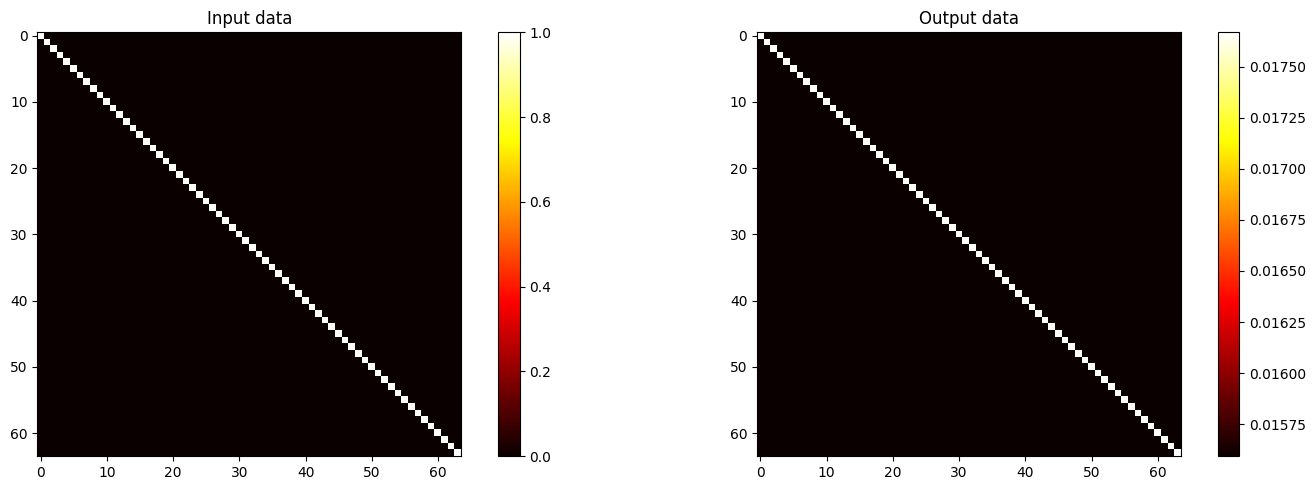

In [20]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('Input data')
plt.imshow(Q_test, cmap='hot', interpolation='nearest')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title('Output data')
plt.imshow(output_sdpa_test, cmap='hot', interpolation='nearest')
plt.colorbar()

plt.tight_layout()
plt.show()

# 4. Put the model together

In [23]:
from google.colab import drive
# drive.flush_and_unmount('/content/drive')
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
# !cd data/datasets/IWSLT2017 && tar zxvf 2017-01-trnmted.tgz
# !cd data/datasets/IWSLT2017/2017-01-trnmted/texts/DeEnItNlRo/DeEnItNlRo && tar zxvf DeEnItNlRo-DeEnItNlRo.tgz

In [25]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

# Define the tokenizers
token_transform = {}
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='de_core_news_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')

# Define function to yield list of tokens
def yield_tokens(data_iter, language):
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

# Define the special tokens
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

# Building vocab
vocab_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    train_iter = IWSLT2017(
        './drive/MyDrive/Colab_Notebooks_Assets/attention_is_all_you_need/data',
        split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE
    ))
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)

# Set UNK_IDX as the default index. This index is returned when the token is not found.
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary.
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/datapipes/utils/common.py:137: UserWarning: Local function is not supported by pickle, please use regular python function or functools.partial instead.
  warnings.warn(


In [26]:
len(vocab_transform[SRC_LANGUAGE])

138280

In [27]:
vocab_transform

{'de': Vocab(), 'en': Vocab()}

In [43]:
from torch.nn.utils.rnn import pad_sequence
from torchtext.data.functional import to_map_style_dataset

batch_size = 32  # specify the batch size

# Define a collate function to process your batches
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_item, tgt_item in batch:
        src_batch.append(torch.tensor([vocab_transform[SRC_LANGUAGE][token] for token in token_transform[SRC_LANGUAGE](src_item)], dtype=torch.long))
        tgt_batch.append(torch.tensor([vocab_transform[TGT_LANGUAGE][token] for token in token_transform[TGT_LANGUAGE](tgt_item)], dtype=torch.long))

    # pad sequences and transpose batch from seq_len x batch_size to batch_size x seq_len
    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX).transpose(0, 1)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX).transpose(0, 1)

    return src_batch, tgt_batch

# Convert your dataset into a map-style dataset (allows for easier batching and shuffling)
train_dataset = to_map_style_dataset(train_iter)

# Create a DataLoader to handle batching of your dataset
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                               shuffle=True, collate_fn=collate_fn)

# Convert your dataset into a map-style dataset (allows for easier batching and shuffling)
val_dataset = to_map_style_dataset(val_iter)

# Create a DataLoader to handle batching of your dataset
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                               shuffle=True, collate_fn=collate_fn)

# Sanity check data loaders
small_train_dataloader = torch.utils.data.DataLoader(torch.utils.data.Subset(train_dataset, range(1000)),
                                                     batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

small_val_dataloader = torch.utils.data.DataLoader(torch.utils.data.Subset(val_dataset, range(400)),
                                                     batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/datapipes/iter/combining.py:297: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


In [44]:
len(train_dataloader)

6441

In [57]:
# Initialize the model
d_model = 512  # whatever your model dimension is
src_vocab_size = len(vocab_transform[SRC_LANGUAGE])
tgt_vocab_size = len(vocab_transform[TGT_LANGUAGE])
print(len(vocab_transform[TGT_LANGUAGE]))
model = Transformer(src_vocab_size, tgt_vocab_size)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.NLLLoss(ignore_index=vocab_transform[TGT_LANGUAGE]['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

59619


In [58]:
num_epochs = 5  # number of epochs to train for

# Lists to store loss, accuracy, and BLEU values for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
bleu_scores = []

for epoch in range(num_epochs):
    model.train()  # set model to training mode
    total_train_loss = 0
    total_train_acc = 0

    # Iterate over the training data
    for i, (src, tgt) in enumerate(train_dataloader):
        # Tokenize and numericalize the source and target sentences
        src = src.to(device)
        tgt = tgt.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(src, tgt[:, :-1])

        # Compute loss
        loss = criterion(output.view(-1, tgt_vocab_size), tgt[:, 1:].reshape(-1))

        # Compute accuracy
        output_flatten = output.view(-1, output.shape[-1])
        tgt_flatten = tgt[:, 1:].reshape(-1)
        non_padding_mask = tgt_flatten.ne(PAD_IDX)
        correct = output_flatten.argmax(1).eq(tgt_flatten).masked_select(non_padding_mask).sum().item()
        total = non_padding_mask.sum().item()
        train_acc = correct / total

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        total_train_loss += loss.item()
        total_train_acc += train_acc

    # Compute the average loss and accuracy for this epoch
    average_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(average_train_loss)
    average_train_acc = total_train_acc / len(train_dataloader)
    train_accuracies.append(average_train_acc)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {average_train_loss}, Train Accuracy: {average_train_acc}')

    # Validation phase
    model.eval()  # set model to evaluation mode
    total_val_loss = 0
    total_val_acc = 0

    with torch.no_grad():
        for i, (src, tgt) in enumerate(val_dataloader):
            # Tokenize and numericalize the source and target sentences
            src = src.to(device)
            tgt = tgt.to(device)

            # Forward pass
            output = model(src, tgt[:, :-1])

            # Compute loss
            loss = criterion(output.view(-1, tgt_vocab_size), tgt[:, 1:].reshape(-1))

            # Compute accuracy
            output_flatten = output.view(-1, output.shape[-1])
            tgt_flatten = tgt[:, 1:].reshape(-1)
            non_padding_mask = tgt_flatten.ne(PAD_IDX)
            correct = output_flatten.argmax(1).eq(tgt_flatten).masked_select(non_padding_mask).sum().item()
            total = non_padding_mask.sum().item()
            val_acc = correct / total

            total_val_loss += loss.item()
            total_val_acc += val_acc

    # Compute the average loss and accuracy for this epoch
    average_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(average_val_loss)
    average_val_acc = total_val_acc / len(val_dataloader)
    val_accuracies.append(average_val_acc)

    print(f'Epoch {epoch+1}/{num_epochs}, Val Loss: {average_val_loss}, Val Accuracy: {average_val_acc}')

Epoch 1/5, Train Loss: 6.432210332431921, Train Accuracy: 0.05786288304909655
Epoch 1/5, Val Loss: 6.55205512046814, Val Accuracy: 0.05134520539735791
Epoch 2/5, Train Loss: 6.395040834122166, Train Accuracy: 0.05835139379533931
Epoch 2/5, Val Loss: 6.555299179894583, Val Accuracy: 0.051454886480967965


KeyboardInterrupt: ignored

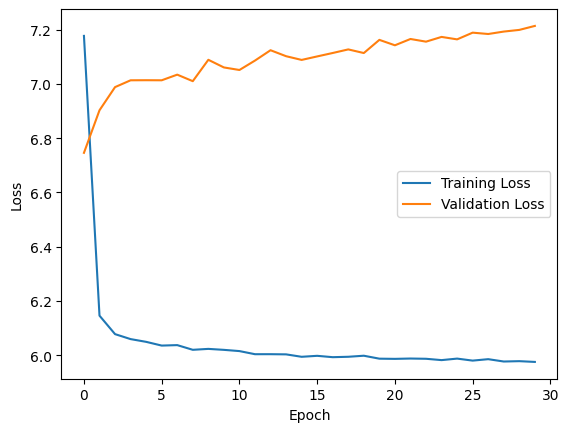

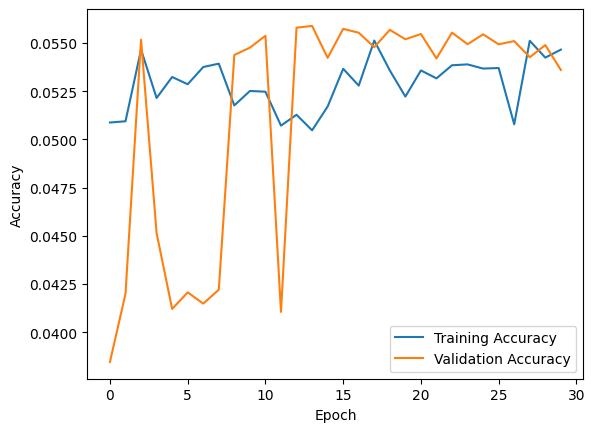

In [54]:
import matplotlib.pyplot as plt

# Create a new figure for the losses
plt.figure()

# Plot the training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')

# Add labels and legend
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()

# Create a new figure for the accuracies
plt.figure()

# Plot the training and validation accuracies
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')

# Add labels and legend
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Show the plot
plt.show()

In [ ]:
len(train_dataloader)

6441

In [ ]:
# torch.save(model.state_dict(), "./drive/MyDrive/Colab_Notebooks_Assets/attention_is_all_you_need/weights/model_weights_07_14.pth")

In [ ]:
# prompt: I want to create a test_dataset and test_dataloader using the same methods I did for training data a few cells up

# Create a test dataset
test_dataset = to_map_style_dataset(test_iter)

# Create a DataLoader to handle batching of your dataset
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                               shuffle=True, collate_fn=collate_fn)

In [ ]:
# prompt: I want to load weights from './drive/MyDrive/Colab_Notebooks_Assets/attention_is_all_you_need/weights/model_weights_07_14.pth' and load them into the model `model`

# Load weights
model.load_state_dict(torch.load("./drive/MyDrive/Colab_Notebooks_Assets/attention_is_all_you_need/weights/model_weights_07_14.pth"))

<All keys matched successfully>

In [ ]:
# prompt: Test the model `model` with the `test` dataset (this is an implementation of a Transformer, doing machine translation), and show me percentage error and BLEU error

from nltk.translate.bleu_score import corpus_bleu
from torchtext.data.metrics import bleu_score

def test_model(model, test_dataloader, criterion):
    model.eval()  # set model to evaluation mode

    # Calculate the percentage error
    percentage_error = 0

    # For BLEU
    # Lists to store references (true translations) and hypotheses (predictions)
    references = []
    hypotheses = []

    # Iterate over the test data
    for i, (src, tgt) in enumerate(test_dataloader):
        # Tokenize and numericalize the source and target sentences
        src = src.to(device)
        tgt = tgt.to(device)

        # Forward pass
        output = model(src, tgt[:, :-1])
        output = output.argmax(dim=-1)
        tgt = tgt[:, 1:]

        # Calculate token-level accuracy
        total_correct_tokens += (output == tgt).sum().item()
        total_tokens += tgt.nelement()

        # Append to references and hypotheses
        references.extend([
            [vocab_transform[TGT_LANGUAGE].get_itos()[idx] for idx in sentence if idx not in {UNK_IDX, PAD_IDX, EOS_IDX, BOS_IDX}]
            for sentence in tgt.tolist()
        ])
        hypotheses.extend([
            [vocab_transform[TGT_LANGUAGE].get_itos()[idx] for idx in sentence if idx not in {UNK_IDX, PAD_IDX, EOS_IDX, BOS_IDX}]
            for sentence in output.tolist()
        ])

    # Print the percentage error
    print(f'Percentage Accurate: {percentage_error}')

    # Calculate BLEU score
    bleu = bleu_score(hypotheses, references)

    print(f'BLEU: {bleu * 100}')

In [ ]:
with torch.no_grad():
    test_model(model, test_dataloader, criterion)
